In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# 1. Load data from .npy files
X_loaded = np.load('/content/X.npy', allow_pickle=True)
y_loaded = np.load('/content/y.npy', allow_pickle=True)

# Reconstruct DataFrame X and Series y from loaded numpy arrays
# The order of columns in X_loaded is assumed to be:
# time, human_activity, luminosity, terrain, presence_of_building, mechanical_activity, nearby_vegetation, x1, ..., x810 (since X_loaded has 817 columns in total)
feature_columns = [
    'time',
    'human_activity',
    'luminosity',
    'terrain',
    'presence_of_building',
    'mechanical_activity',
    'nearby_vegetation'
] + [f'x{i}' for i in range(1, 811)] # Adjusted range to match 817 columns (7 explicit + 810 'x' features)

X = pd.DataFrame(X_loaded, columns=feature_columns)
y = pd.Series(y_loaded, name='safety')

print("Original DataFrame head (reconstructed from .npy):")
print(X.head())
print("\nOriginal Series head (reconstructed from .npy):")
print(y.head())

# --- FIX: Remove the 'Safety' class with only one member ---
# This fix was added in the previous step to handle ValueError from train_test_split
initial_safety_counts = y.value_counts()
if 'Safety' in initial_safety_counts.index and initial_safety_counts['Safety'] == 1:
    print("\nRemoving 'Safety' category as it has only 1 member.")
    # Filter both X and y to remove rows associated with the 'Safety' category
    mask = y != 'Safety'
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)

print("\nValue counts for 'safety' column (after cleaning):")
print(y.value_counts())

# Define the columns that should be explicitly treated as categorical
explicitly_categorical_cols = [
    'time',
    'luminosity',
    'terrain',
    'nearby_vegetation',
    'human_activity',
    'presence_of_building',
    'mechanical_activity'
]

# Initialize lists for numerical and categorical columns for the preprocessor
numerical_cols = []
categorical_cols = []

# Process columns based on explicit definition and type inference
for col in X.columns:
    if col in explicitly_categorical_cols:
        X[col] = X[col].astype(str) # Ensure it's string type for OneHotEncoder
        categorical_cols.append(col)
    else:
        # For other columns, attempt to convert to numeric
        temp_numeric = pd.to_numeric(X[col], errors='coerce')
        if not temp_numeric.isnull().all(): # If it successfully converts to numeric (not all NaNs)
            X[col] = temp_numeric # Update the column in X with numeric values
            numerical_cols.append(col)
        else:
            # If it could not be converted to numeric, treat as categorical
            X[col] = X[col].astype(str) # Ensure it's string type
            categorical_cols.append(col)


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute NaNs with the mean
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 3. Encode the target variable 'safety' into numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the mapping
print("\nSafety categories mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category} -> {i}")

# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"\nTraining set shape (before preprocessing): {X_train.shape}")
print(f"Testing set shape (before preprocessing): {X_test.shape}")

# 5. Apply preprocessing to the training and testing sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nFeatures preprocessed and scaled.")
print(f"Training set shape (after preprocessing): {X_train_processed.shape}")
print(f"Testing set shape (after preprocessing): {X_test_processed.shape}")

# 6. Initialize and train the SVM model with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_processed, y_train)

print("\nSVM model (RBF kernel) trained successfully.")

# 7. Make predictions on the test set
y_pred = svm_model.predict(X_test_processed)

# 8. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
# Convert label_encoder.classes_ to a list of strings
target_names_str = [str(cls) for cls in label_encoder.classes_]
report = classification_report(y_test, y_pred, target_names=target_names_str)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Example of predicting a new sample (optional)
# To predict a new sample, it would also need to go through the same preprocessing pipeline.
# new_sample_data = {'time': ['Night'], 'human_activity': [0], 'luminosity': ['Well_Lit'],
#                    'terrain': ['Road'], 'presence_of_building': [0], 'mechanical_activity': [0],
#                    'nearby_vegetation': ['Low'], **{f'x{i}': [np.random.rand()] for i in range(1, 511)}}
# new_sample_df = pd.DataFrame(new_sample_data)
# new_sample_processed = preprocessor.transform(new_sample_df)
# predicted_class_encoded = svm_model.predict(new_sample_processed)
# predicted_class_label = label_encoder.inverse_transform(predicted_class_encoded)
# print(f"\nPrediction for a new sample: {predicted_class_label[0]}")

Original DataFrame head (reconstructed from .npy):
       time  human_activity  luminosity   terrain  presence_of_building  \
0  0.491731        0.445704    0.536442  0.337588              0.312587   
1  0.485678        0.530327    0.436576  0.362194              0.236883   
2  0.503587        0.503648    0.495329  0.454812              0.436726   
3  0.513355        0.506937    0.520861  0.428034              0.364365   
4  0.508415        0.506770    0.551365  0.616755              0.669093   

   mechanical_activity  nearby_vegetation        x1        x2        x3  ...  \
0             0.293664           0.385367  0.252270  0.308534  0.444599  ...   
1             0.213763           0.298091  0.220172  0.236897  0.449872  ...   
2             0.450115           0.462686  0.467707  0.441645  0.410032  ...   
3             0.360623           0.441920  0.361150  0.355209  0.419322  ...   
4             0.707021           0.600519  0.735107  0.693003  0.388642  ...   

       x801      

In [ ]:
print(f"Number of numerical features: {len(numerical_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")

Number of numerical features: 810
Number of categorical features: 7


Training Accuracy: 0.8166
Testing Accuracy: 0.7226
Training Error: 0.1834
Testing Error: 0.2774


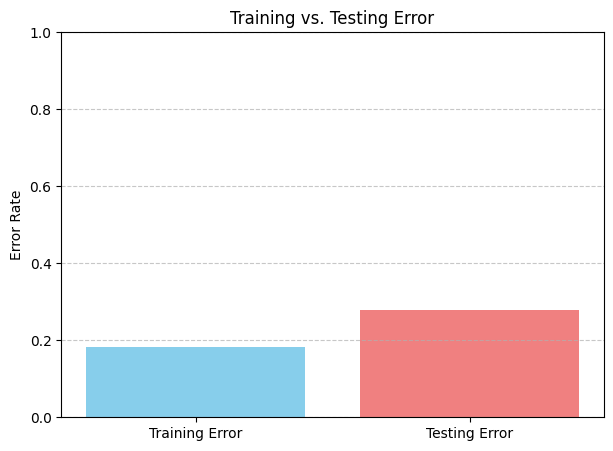

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predict on the training set
y_train_pred = svm_model.predict(X_train_processed)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

# Calculate errors
train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Training Error: {train_error:.4f}")
print(f"Testing Error: {test_error:.4f}")

# Plotting the errors
labels = ['Training Error', 'Testing Error']
errors = [train_error, test_error]

plt.figure(figsize=(7, 5))
plt.bar(labels, errors, color=['skyblue', 'lightcoral'])
plt.ylabel('Error Rate')
plt.title('Training vs. Testing Error')
plt.ylim(0, 1) # Error rate is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


--- Confusion Matrix ---


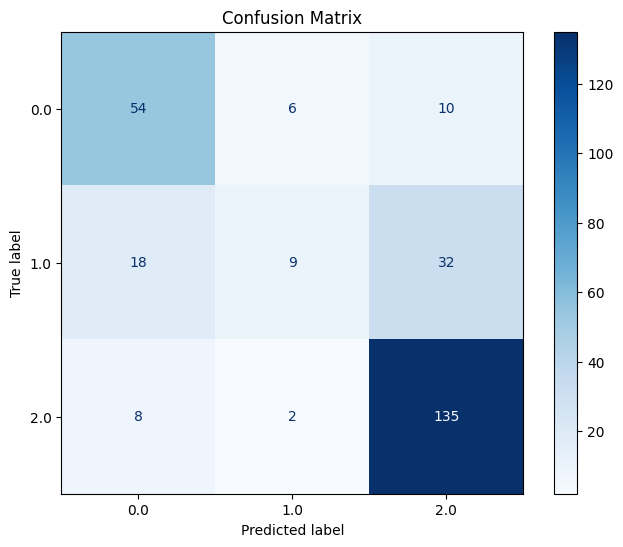


--- ROC Curve (One-vs-Rest) ---


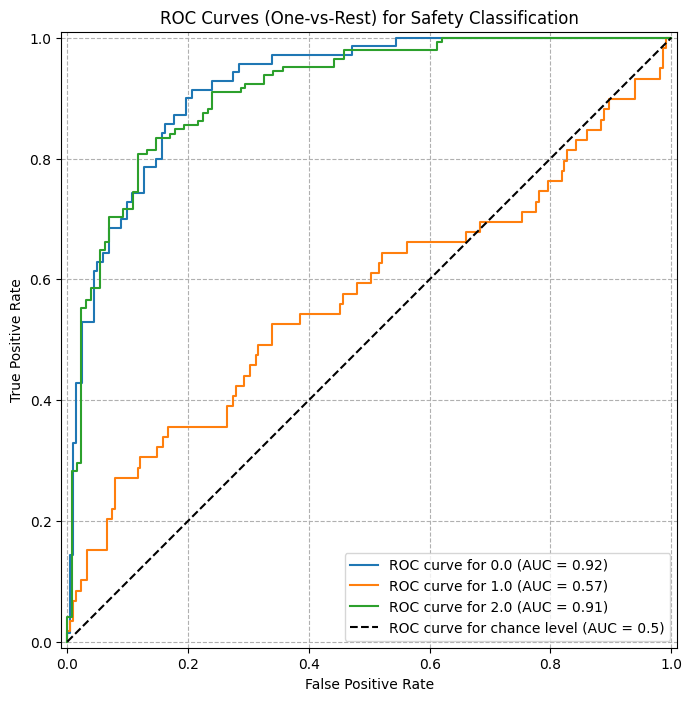


--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72        70
         1.0       0.53      0.15      0.24        59
         2.0       0.76      0.93      0.84       145

    accuracy                           0.72       274
   macro avg       0.66      0.62      0.60       274
weighted avg       0.69      0.72      0.68       274



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Convert label_encoder.classes_ to a list of strings for display and reporting
target_names_str = [str(cls) for cls in label_encoder.classes_]

# --- Plotting Confusion Matrix ---
print("\n--- Confusion Matrix ---")
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_str)
disp_cm.plot(cmap=plt.cm.Blues, ax=ax_cm)
ax_cm.set_title('Confusion Matrix')
plt.show()

# --- Plotting ROC Curve (One-vs-Rest) ---
print("\n--- ROC Curve (One-vs-Rest) ---")
# Get decision function scores for each class
y_score = svm_model.decision_function(X_test_processed)

# Binarize the true labels for one-vs-rest ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
for i, class_label in enumerate(target_names_str):
    RocCurveDisplay.from_predictions(
        y_test_binarized[:, i],
        y_score[:, i],
        name=f"ROC curve for {class_label}",
        ax=ax_roc
    )

ax_roc.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
ax_roc.set_title('ROC Curves (One-vs-Rest) for Safety Classification')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()
plt.grid(linestyle='--')
plt.show()

# --- Re-display Classification Report ---
print("\n--- Classification Report ---")
report = classification_report(y_test, y_pred, target_names=target_names_str)
print(report)
